# Task 3 - ZNE

Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of interest.

### Instructions

In this task, you will build a simple ZNE function from scratch:

1.   Build a simple noise model with depolarizing noise
2.  Create different circuits to test your noise models and choose the observable to measure  **#not done**
3.  Apply the unitary folding method.
4.  Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential. **apply poly_fir method**
5.  Compare mitigated and unmitigated results
6.  Bonus: Run your ZNE function in real quantum hardware through the **IBM Quantum Service**.

Check the [Mitiq documentation](https://mitiq.readthedocs.io/en/stable/guide/zne-5-theory.html) for references. You are not allowed to use the functions from Mitiq or any other frameworks where ZNE is already implemented.

##### Deadline

Form filled - 12-03-24, Deadline - 26-03-24 ([**Submission link**](https://forms.gle/dJdYz74EYfwjSTzL9))

##### Installing libraries and dependencies

In [1]:
!pip install pennylane
!pip install pennylane-qiskit
!pip install amazon-braket-pennylane-plugin

##### ZNE

In [2]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.transforms import mitigate_with_zne  # ZNE implementation using pennylane

from matplotlib import pyplot as plt

In [3]:
n_wires = 4
np.random.seed(1234)


# building our custom hamiltonian
coeffs = [1.0] * (n_wires - 1) + [0.5] * n_wires
observables = [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(n_wires - 1)]
observables += [qml.PauliZ(i) for i in range(n_wires)]

H = qml.Hamiltonian(coeffs, observables)

print(np.array(coeffs))
print("\n Hamiltonian =",H)

[1.  1.  1.  0.5 0.5 0.5 0.5]

 Hamiltonian =   (0.5) [Z0]
+ (0.5) [Z1]
+ (0.5) [Z2]
+ (0.5) [Z3]
+ (1.0) [X0 X1]
+ (1.0) [X1 X2]
+ (1.0) [X2 X3]


In [4]:
n_layers = 2

w1 = np.ones((n_wires), requires_grad=True)
w2 = np.ones((n_layers, n_wires - 1, 2), requires_grad=True)

print(np.shape(w2))

(2, 3, 2)


In [7]:
def ansatz_cost(w1, w2):
    qml.SimplifiedTwoDesign(w1, w2, wires=range(n_wires))
    return qml.expval(H)

print(qml.draw(ansatz_cost)(w1,w2))

0: ─╭SimplifiedTwoDesign─┤ ╭<𝓗>
1: ─├SimplifiedTwoDesign─┤ ├<𝓗>
2: ─├SimplifiedTwoDesign─┤ ├<𝓗>
3: ─╰SimplifiedTwoDesign─┤ ╰<𝓗>


Applying richardson's extrapolation for mitigation.

In [8]:
# Depolarizing noise
noise_gate = qml.DepolarizingChannel
noise_strength = 0.05

dev_ideal = qml.device("default.mixed", wires=n_wires)
dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength, position="all")

scale_factors=[1, 2, 3]

qnode_ideal = qml.QNode(ansatz_cost, dev_ideal) # ideal qnode
qnode_noisy = qml.QNode(ansatz_cost, dev_noisy) #noisy qnode
qnode_mitigated = mitigate_with_zne(qnode_noisy,
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.richardson_extrapolate,
) # mitigated qnode

print("Ideal QNode: ", qnode_ideal(w1, w2))
print("Mitigated QNode: ", qnode_mitigated(w1, w2))
print("Noisy QNode: ", qnode_noisy(w1, w2))

Ideal QNode:  0.7786752842284947
Mitigated QNode:  0.6001417137223949
Noisy QNode:  0.30459632191309644


In the code below we prin the **folding schemes** for various types of global_folding scales in the vector scale_factors. For folding rep=0 the first circuit is basically unchanged. The second circuit has global_folding with 1 rep and the last circuit has global folding for 2 reps. This amplifies the noise levels. Below I have printed each to help visualize the circuits better.

[<QNode: wires=4, device='default.mixed', interface='auto', diff_method='best'>, <QNode: wires=4, device='default.mixed', interface='auto', diff_method='best'>, <QNode: wires=4, device='default.mixed', interface='auto', diff_method='best'>] 




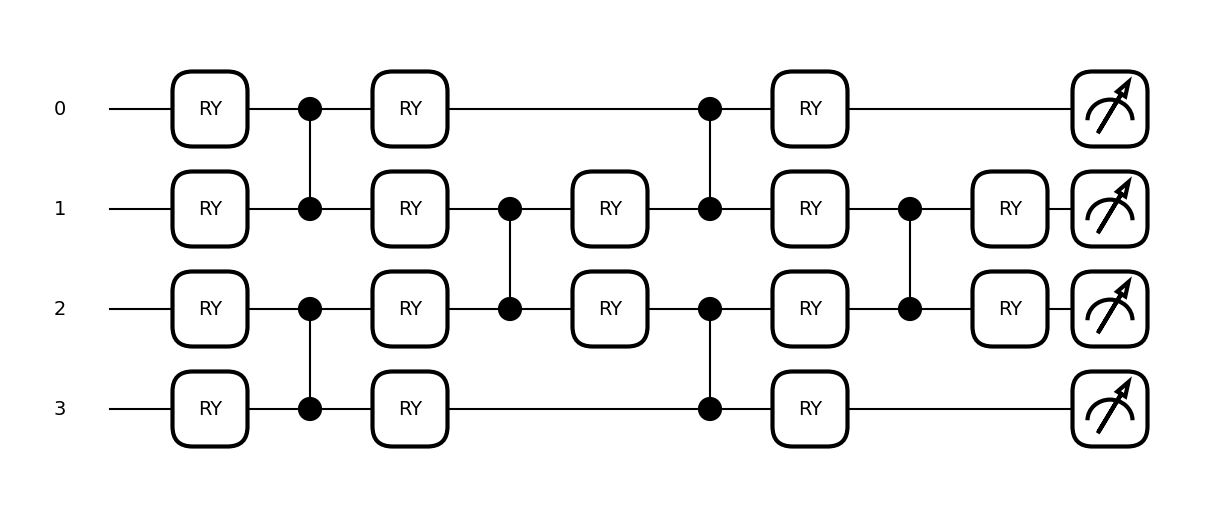

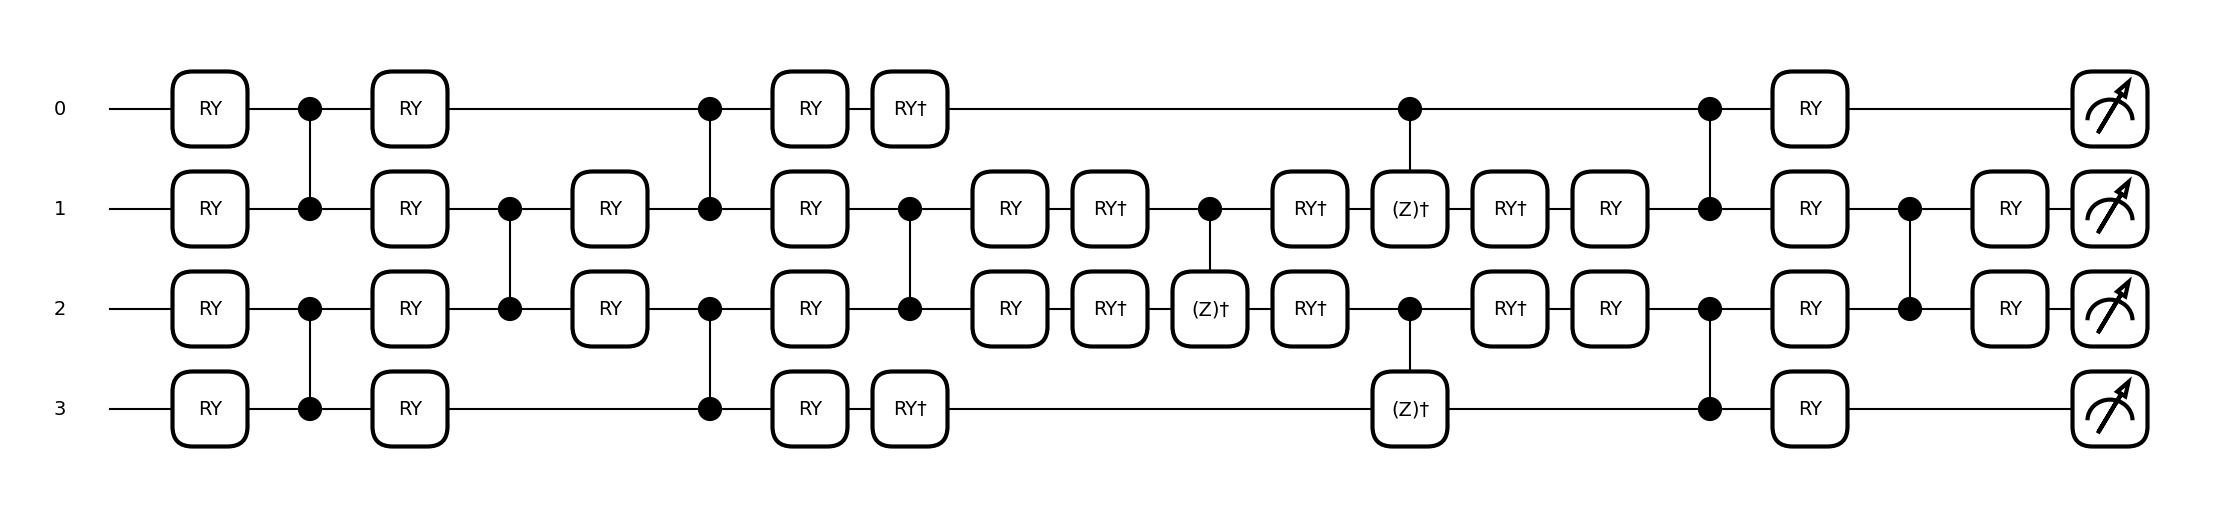

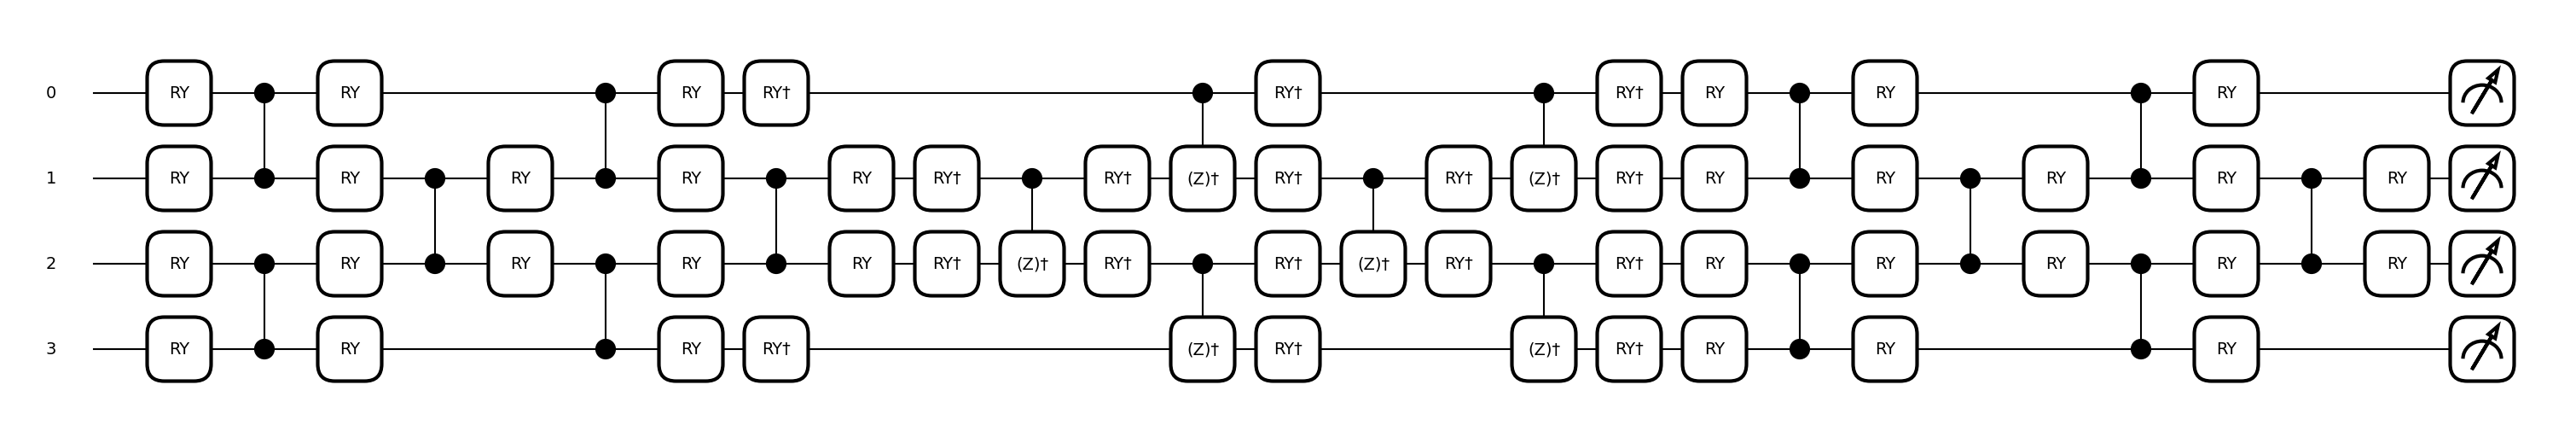

In [9]:
folded_circuits = [qml.transforms.fold_global(qnode_noisy, scale_factor) for scale_factor in scale_factors]
print(folded_circuits,"\n\n")

for i in range(len(folded_circuits)):
  drawing, ax = qml.draw_mpl(folded_circuits[i])(w1,w2)
  fig = drawing.figure
  """fig.set_figwidth(16)
  fig.set_figheight(2.5)"""
  drawing.show()

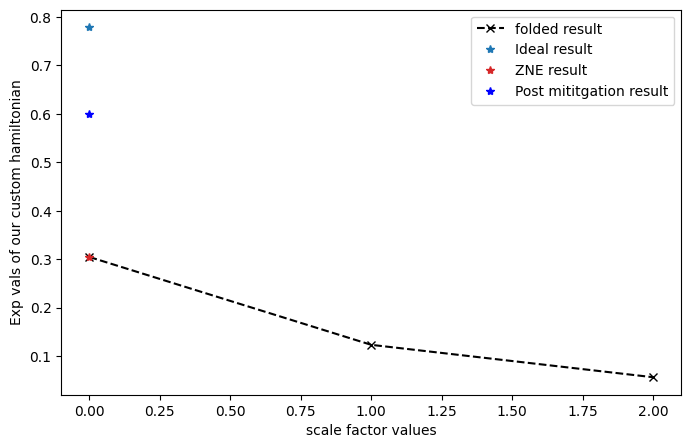

In [10]:
scale_factors = [1, 2, 3]
folded_res = [
    qml.transforms.fold_global(qnode_noisy, lambda_)(w1, w2) for lambda_ in scale_factors
]

ideal_res = qnode_ideal(w1, w2)
mitigated_res = qnode_mitigated(w1,w2)

coeffs = np.polyfit([scale_factor-1 for scale_factor in scale_factors], folded_res, 2)
zne_res = coeffs[-1]

plt.figure(figsize=(8, 5))
plt.plot([scale_factor-1 for scale_factor in scale_factors], folded_res, "x--", label="folded result",color="k")
plt.plot(0, ideal_res, "*", label="Ideal result")
plt.plot(0, zne_res, "*", label="ZNE result", color="tab:red")
plt.plot(0, mitigated_res, "*", label="Post mititgation result", color= "b")
plt.xlabel("scale factor values")
plt.ylabel("Exp vals of our custom hamiltonian")
plt.legend()
plt.show()

With each iteration of circuit folding the results keep getting worse as the noise increases

In [11]:
def VQE_run(cost_fn, max_iter, stepsize=0.1):
    """VQE Optimization loop"""
    opt = qml.SPSAOptimizer(maxiter= max_iter)

    # fixed initial guess
    w1 = np.ones((n_wires), requires_grad=True)
    w2 = np.ones((n_layers, n_wires - 1, 2), requires_grad=True)

    energy = []

    # Optimization loop
    for n in range(max_iter):
        (w1, w2), prev_energy = opt.step_and_cost(cost_fn, w1, w2)

        energy.append(prev_energy)
        if (n%50 == 0):
          print("Energy optimization at ",n,"th step is : ",energy[-1])

    energy.append(cost_fn(w1, w2)) # final addition to the last updated params
    print("\n")
    return energy # energy list


max_iter = 200

energy_ideal = VQE_run(qnode_ideal, max_iter)
energy_noisy = VQE_run(qnode_noisy, max_iter)
energy_mitigated = VQE_run(qnode_mitigated, max_iter)

energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(H)))

Energy optimization at  0 th step is :  0.7786752842284947
Energy optimization at  50 th step is :  -2.695922547289679
Energy optimization at  100 th step is :  -3.3174803311077237
Energy optimization at  150 th step is :  -3.3531588678753272


Energy optimization at  0 th step is :  0.30459632191309644
Energy optimization at  50 th step is :  -0.5249737207477212
Energy optimization at  100 th step is :  -0.9781920122957625
Energy optimization at  150 th step is :  -1.1805748942076235


Energy optimization at  0 th step is :  0.6001417137223949
Energy optimization at  50 th step is :  -2.1797780723766187
Energy optimization at  100 th step is :  -2.341494133832614
Energy optimization at  150 th step is :  -2.43630096262002




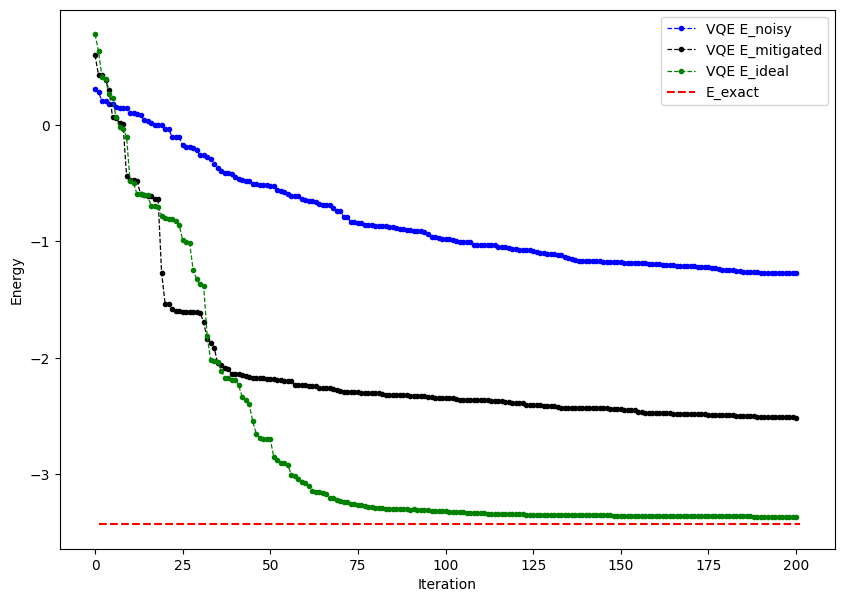

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(energy_noisy, "--.", label="VQE E_noisy",color= "blue",linewidth = 0.9)
plt.plot(energy_mitigated, "--.", label="VQE E_mitigated", color = "black",linewidth = 0.9)
plt.plot(energy_ideal, "--.", label="VQE E_ideal", color = "green",linewidth = 0.9)
plt.plot([1, max_iter + 1], [energy_exact] * 2, "--", label="E_exact", color = "red")
plt.legend(fontsize=10)
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.show()

Trying the polynomial extrapolation with a different hamiltonian.

In [13]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Describe noise
noise_strength = 0.005
scale_factors= [1,3,5]

dev = qml.device('default.mixed', wires=2)  # Ideal device
dev_noisy = qml.transforms.insert(dev, qml.DepolarizingChannel, noise_strength)  # Noisy device

# Observable to measure
np.random.seed(1)
coeffs = np.random.rand(6)
obs = [qml.X(0) @ qml.Y(1), qml.Y(0) @ qml.Z(1),qml.Z(0)@qml.X(1),qml.Y(0)@qml.X(1),qml.Z(0)@qml.Y(1),qml.X(0)@qml.Z(1)]
Hamiltonian = qml.Hamiltonian(coeffs, obs)
print(Hamiltonian)


layers = 2
qubits = len(Hamiltonian.wires)
# Define the variational circuit
def variational_circuit(gamma):
  if(len(gamma)==4):
    qml.RY(gamma[0],wires=0)
    qml.RZ(gamma[0],wires=1)
    qml.CNOT([0,1])
    qml.RZ(gamma[2],wires=0)
    qml.RY(gamma[3],wires=1)

    return qml.expval(Hamiltonian)

  (0.00011437481734488664) [Z0 X1]
+ (0.0923385947687978) [X0 Z1]
+ (0.14675589081711304) [Z0 Y1]
+ (0.30233257263183977) [Y0 X1]
+ (0.417022004702574) [X0 Y1]
+ (0.7203244934421581) [Y0 Z1]


In [14]:
params = np.random.rand(4)
print(params,"\n")

qnode_ideal = qml.QNode(variational_circuit, dev_ideal) # ideal qnode
qnode_noisy = qml.QNode(variational_circuit, dev_noisy) #noisy qnode
qnode_mitigated = mitigate_with_zne(qnode_noisy,
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.poly_extrapolate, extrapolate_kwargs={'order': 2} # linear for order = 1, quadratic for order = 2, richardson = variable order
) # mitigated qnode

print("New Hamiltonian:\nIdeal val: ",qnode_ideal(params),"\nNoisy val: ",qnode_noisy(params),"\nMitigated val: ",qnode_mitigated(params))

[0.18626021 0.34556073 0.39676747 0.53881673] 

New Hamiltonian:
Ideal val:  0.013929090722776823 
Noisy val:  0.013278526362717332 
Mitigated val:  0.013978828298987058


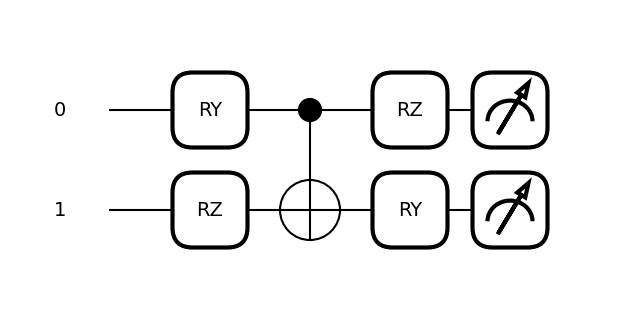

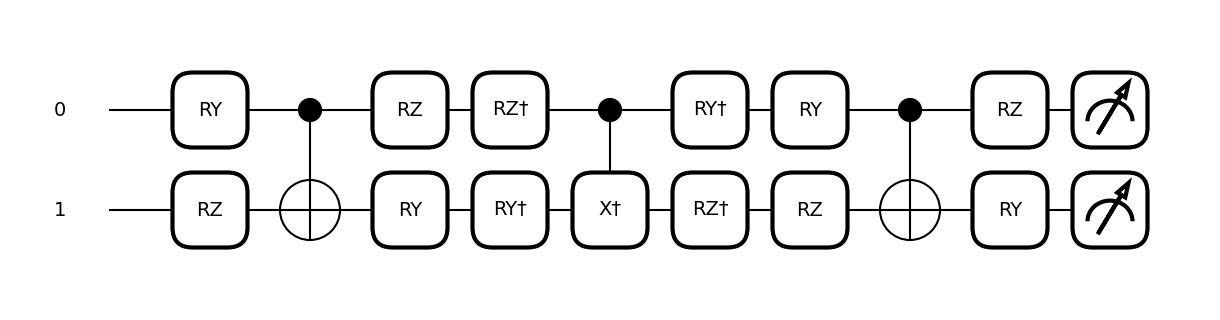

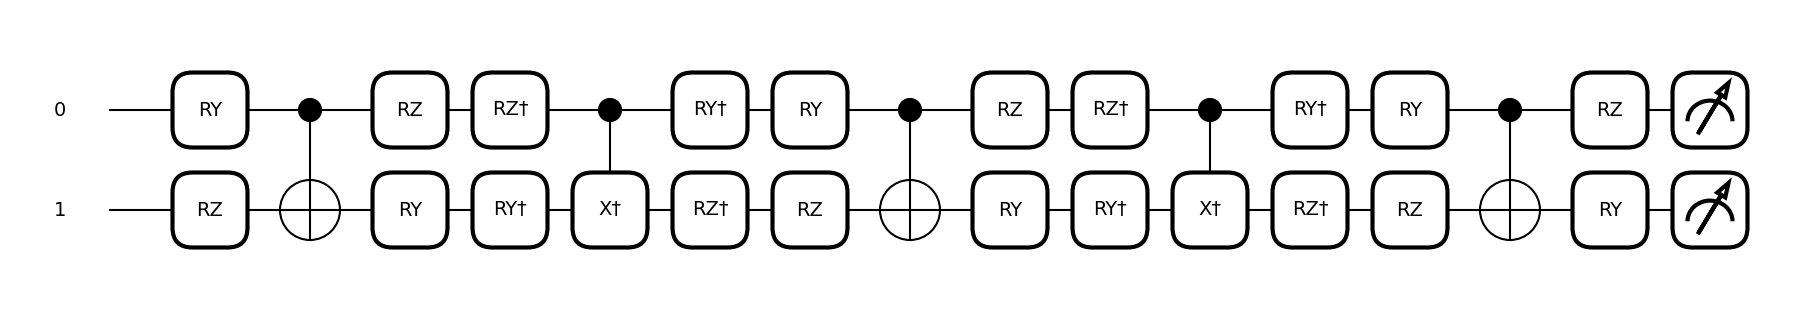

In [15]:
folded_circuits = [qml.transforms.fold_global(qnode_noisy, scale_factor) for scale_factor in scale_factors]
for i in range(len(folded_circuits)):
  drawing, ax = qml.draw_mpl(folded_circuits[i])(params)
  fig = drawing.figure
  drawing.show()

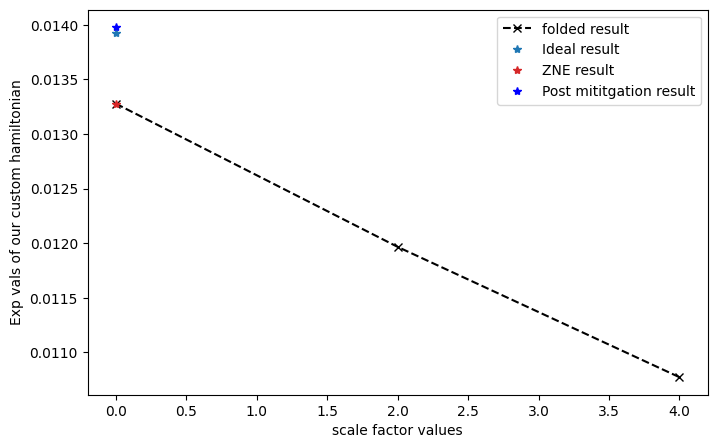

In [16]:
folded_res = [
    qml.transforms.fold_global(qnode_noisy, lambda_)(params) for lambda_ in scale_factors
]

ideal_res = qnode_ideal(params)
mitigated_res = qnode_mitigated(params)

coeffs = np.polyfit([scale_factor-1 for scale_factor in scale_factors], folded_res, 2)
zne_res = coeffs[-1]

plt.figure(figsize=(8, 5))
plt.plot([scale_factor-1 for scale_factor in scale_factors], folded_res, "x--", label="folded result",color="k")
plt.plot(0, ideal_res, "*", label="Ideal result")
plt.plot(0, zne_res, "*", label="ZNE result", color="tab:red")
plt.plot(0, mitigated_res, "*", label="Post mititgation result", color= "b")
plt.xlabel("scale factor values")
plt.ylabel("Exp vals of our custom hamiltonian")
plt.legend()
plt.show()

In [18]:
def VQE_new(cost_fn, max_iter, stepsize=0.1):
    """VQE Optimization loop"""
    opt = qml.SPSAOptimizer(maxiter= max_iter)

    #init guess
    params = np.ones(4)

    energy = []

    # Optimization loop
    for n in range(max_iter):
        params, prev_energy = opt.step_and_cost(cost_fn, params)

        energy.append(prev_energy)
        if (n%50 == 0):
          print("Energy optimization at ",n,"th step is : ",energy[-1])

    energy.append(cost_fn(params)) # final addition to the last updated params
    print("\n")
    return energy # energy list


max_iter = 100

energy_ideal = VQE_new(qnode_ideal, max_iter)
energy_noisy = VQE_new(qnode_noisy, max_iter)
energy_mitigated = VQE_new(qnode_mitigated, max_iter)

energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(H)))

Energy optimization at  0 th step is :  -0.053469458404831
Energy optimization at  50 th step is :  -0.2415040002081444


Energy optimization at  0 th step is :  -0.053614548234584634
Energy optimization at  50 th step is :  -0.24886693635572715


Energy optimization at  0 th step is :  -0.052326481467933526
Energy optimization at  50 th step is :  -0.2684806397547093




In [19]:
energy_exact = np.min(qml.eigvals(Hamiltonian))
energy_exact

/usr/local/lib/python3.10/dist-packages/pennylane/ops/functions/eigvals.py:120: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


-1.2396306291797432

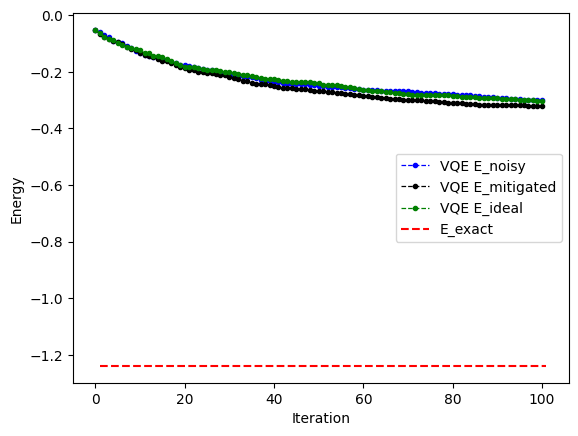

In [22]:
plt.plot(energy_noisy, "--.", label="VQE E_noisy",color= "blue",linewidth = 0.9)
plt.plot(energy_mitigated, "--.", label="VQE E_mitigated", color = "black",linewidth = 0.9)
plt.plot(energy_ideal, "--.", label="VQE E_ideal", color = "green",linewidth = 0.9)
plt.plot([1, max_iter + 1], [energy_exact] * 2, "--", label="E_exact", color = "red")
plt.legend(fontsize=10)
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.show()